In [1]:
# Alina Artemiuk
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time

In [2]:
warnings.filterwarnings("ignore")

In [3]:
seed = 123
np.random.seed(seed)

In [4]:
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, value=None, left_branch=None, right_branch=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.value = value
        self.left_branch = left_branch
        self.right_branch = right_branch


class DecisionTree:
    def __init__(self, criterion="entropy", max_depth=None):
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth

    def _entropy(self, y):
        """
        Compute the entropy of a given target vector.

        Parameters:
        y (list): Target labels.

        Returns:
        float: The computed entropy.
        """
        unique, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def _gini(self, y):
        """
        Compute the gini impurity of a given target vector.

        Parameters:
        y (list): Target labels.

        Returns:
        float: The computed gini impurity.
        """
        unique, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - np.sum(np.square(probabilities))

    def _information_gain(self, y, y_left, y_right):
        """
        Compute the information gain of a given split.

        Parameters:
        y (list): Original target labels.
        y_left (list): Left split target labels.
        y_right (list): Right split target labels.

        Returns:
        float: The computed information gain.
        """
        p_left = len(y_left) / len(y)
        p_right = len(y_right) / len(y)

        if self.criterion == "entropy":
            impurity = self._entropy
        elif self.criterion == "gini":
            impurity = self._gini
        else:
            raise ValueError("Unknown impurity measure")

        return impurity(y) - p_left * impurity(y_left) - p_right * impurity(y_right)

    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split on.

        Parameters:
        X (np.array): Features.
        y (list): Target labels.

        Returns:
        tuple: Best gain, threshold, and feature index for the split.
        """
        best_gain, best_threshold, best_index = 0, None, None
        for index in range(X.shape[1]):
            thresholds = np.unique(X[:, index])
            for threshold in thresholds:
                y_left = y[X[:, index] <= threshold]
                y_right = y[X[:, index] > threshold]
                info_gain = self._information_gain(y, y_left, y_right)
                if info_gain > best_gain:
                    best_gain, best_threshold, best_index = info_gain, threshold, index
        return best_gain, best_threshold, best_index

    def _learn(self, X, y, current_depth=0):
        """
        Recursively build the decision tree.

        Parameters:
        X (np.array): Features.
        y (list): Target labels.

        Returns:
        DecisionNode: Root node of the built decision tree.
        """
        if self.max_depth is not None and current_depth == self.max_depth:
            return DecisionNode(value=np.bincount(y).argmax())

        # check if all the data points have the same label
        unique_labels = np.unique(y)

        # if they do, then return a leaf node with that label
        if len(unique_labels) == 1:
            return DecisionNode(value=unique_labels[0])

        # check if all data points have identical feature values
        if np.all(X == X[0]):
            return DecisionNode(value=np.bincount(y).argmax())

        # calculate the best split (feature) based on the criterion
        gain, threshold, index = self._best_split(X, y)

        # if there is no gain in splitting (no improvement), return a leaf with the most common label
        if gain == 0:
            return DecisionNode(value=np.bincount(y).argmax())

        # partition the dataset based on the best feature's threshold
        left_indices = X[:, index] <= threshold
        right_indices = X[:, index] > threshold

        # print(current_depth)

        # recursively build the left and right branches of the tree
        left_branch = self._learn(X[left_indices], y[left_indices], current_depth + 1)
        right_branch = self._learn(X[right_indices], y[right_indices], current_depth + 1)

        # return a decision node that contains the best feature to split on and its corresponding threshold
        return DecisionNode(feature_index=index, threshold=threshold, left_branch=left_branch,
                            right_branch=right_branch)

    def predict(self, x, node=None):
        """
        Predict the target label for a given feature vector.

        Parameters:
        x (np.array): Single feature vector.
        node (DecisionNode, optional): Current node in the decision tree.

        Returns:
        int: Class label of data point x.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            return node.value

        feature_value = x[node.feature_index]
        if feature_value <= node.threshold:
            return self.predict(x, node.left_branch)
        else:
            return self.predict(x, node.right_branch)

    def _accuracy(self, X, y_true, node=None):
        """
        Compute the accuracy of predictions.

        Parameters:
        X (np.array): Features.
        y_true (list): True target labels.
        node (DecisionNode, optional): Current node in the decision tree.

        Returns:
        float: The accuracy of predictions.
        """
        y_pred = [self.predict(x, node) for x in X]
        return np.mean(np.array(y_pred) == y_true)

    def _prune(self, node, y_train, X_prune, y_prune):
        """
        Recursively prune the decision tree using reduced-error pruning.
    
        Parameters:
        node (DecisionNode): Current node to consider for pruning.
        y_train (list): Target labels from the training data.
        X_prune (np.array): Features of the pruning set.
        y_prune (list): Target labels of the pruning set.
    
        Returns:
        DecisionNode: Pruned node. It may be the same node, a modified version, or a replacement (e.g., a leaf node).
        """
        # if this is a leaf node
        if node.value is not None:
            return node

        # recursively prune left and right branches
        node.left_branch = self._prune(node.left_branch, y_train, X_prune, y_prune)
        node.right_branch = self._prune(node.right_branch, y_train, X_prune, y_prune)

        original_accuracy = self._accuracy(X_prune, y_prune, node)

        # replace the node with a leaf node of the majority class using training data
        majority_class = np.bincount(y_train).argmax()
        replaced_node = DecisionNode(value=majority_class)

        # accuracy with the replaced node
        replaced_accuracy = self._accuracy(X_prune, y_prune, replaced_node)

        # if the new accuracy has not decreased, replace the node
        if replaced_accuracy >= original_accuracy:
            return replaced_node

        return node

    def learn(self, X, y, prune=False, pruning_ratio=0.2):
        """
        Build the decision tree from data.

        Parameters:
        X (np.array): Features.
        y (list): Target labels.
        prune (bool, optional): Whether to prune the tree or not.
        pruning_ratio (float, optional): Ratio of data to use for pruning.
        """
        if prune:
            X_train, X_prune, y_train, y_prune = train_test_split(X, y, test_size=pruning_ratio, random_state=seed)

            self.root = self._learn(X_train, y_train)

            self.root = self._prune(self.root, y_train, X_prune, y_prune)

        else:
            self.root = self._learn(X, y)

    def compute_feature_importance(self, X, y, node=None):
        """
        Compute the importance of each feature based on the information gain it provides.
        
        Parameters:
        X (np.array): Features.
        y (list): Target labels.
        node (DecisionNode, optional): The current node being considered. If None, starts from the root.
        """
        if node is None:
            node = self.root
            self.feature_importances_ = np.zeros(X.shape[1])

        if node.value is not None:
            return

        left_indices = X[:, node.feature_index] <= node.threshold
        right_indices = ~left_indices

        left_size = np.sum(left_indices)
        right_size = np.sum(right_indices)

        total_size = left_size + right_size
        gain = self._information_gain(y, y[left_indices], y[right_indices])
        self.feature_importances_[node.feature_index] += (gain * total_size / len(y))

        self.compute_feature_importance(X, y, node.left_branch)
        self.compute_feature_importance(X, y, node.right_branch)

        if node == self.root:
            self.feature_importances_ /= self.feature_importances_.sum()

    def print_tree(self, node=None, spacing=""):
        """
        Print the decision tree in a readable format.
    
        Parameters:
        node (DecisionNode, optional): The current node being considered. If None, starts from the root.
        spacing (str, optional): Used for indentation to visualize tree depth.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            print(spacing + "Predict", node.value)
            return

        print(spacing + f"[Feature {node.feature_index} <= {node.threshold}]")
        print(spacing + "--> Left:")
        self.print_tree(node.left_branch, spacing + "  ")

        print(spacing + "--> Right:")
        self.print_tree(node.right_branch, spacing + "  ")

## Data Exploration

In [5]:
df = pd.read_csv("wine_dataset.csv")

In [6]:
df.head()

,citric acid,residual sugar,pH,sulphates,alcohol,type
0,0.13,1.60,3.34,0.59,9.2,1
1,0.10,2.80,3.60,0.66,10.2,1
2,0.32,1.90,3.20,0.55,9.5,1
3,0.29,13.65,3.00,0.60,9.5,0
4,0.26,2.00,3.41,0.74,9.2,1


In [7]:
df.shape

(3198, 6)

In [8]:
df.describe()

,citric acid,residual sugar,pH,sulphates,alcohol,type
count,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,0.301776,4.449781,3.249678,0.574431,10.459725,0.500000
std,0.165284,4.214445,0.163439,0.165587,1.143231,0.500078
min,0.000000,0.600000,2.740000,0.220000,8.000000,0.000000
25%,0.210000,1.900000,3.140000,0.470000,9.500000,0.000000
50%,0.300000,2.400000,3.240000,0.550000,10.200000,0.500000
75%,0.400000,5.937500,3.360000,0.650000,11.200000,1.000000
max,1.660000,65.800000,4.010000,2.000000,14.900000,1.000000


In [9]:
df["type"].value_counts()

type
1    1599
0    1599
Name: count, dtype: int64

In [10]:
X = df.drop("type", axis=1).values
features = df.drop("type", axis=1).columns
y = df["type"].values

## Data Visualization

### Pairplot to visualize relationships and distributions

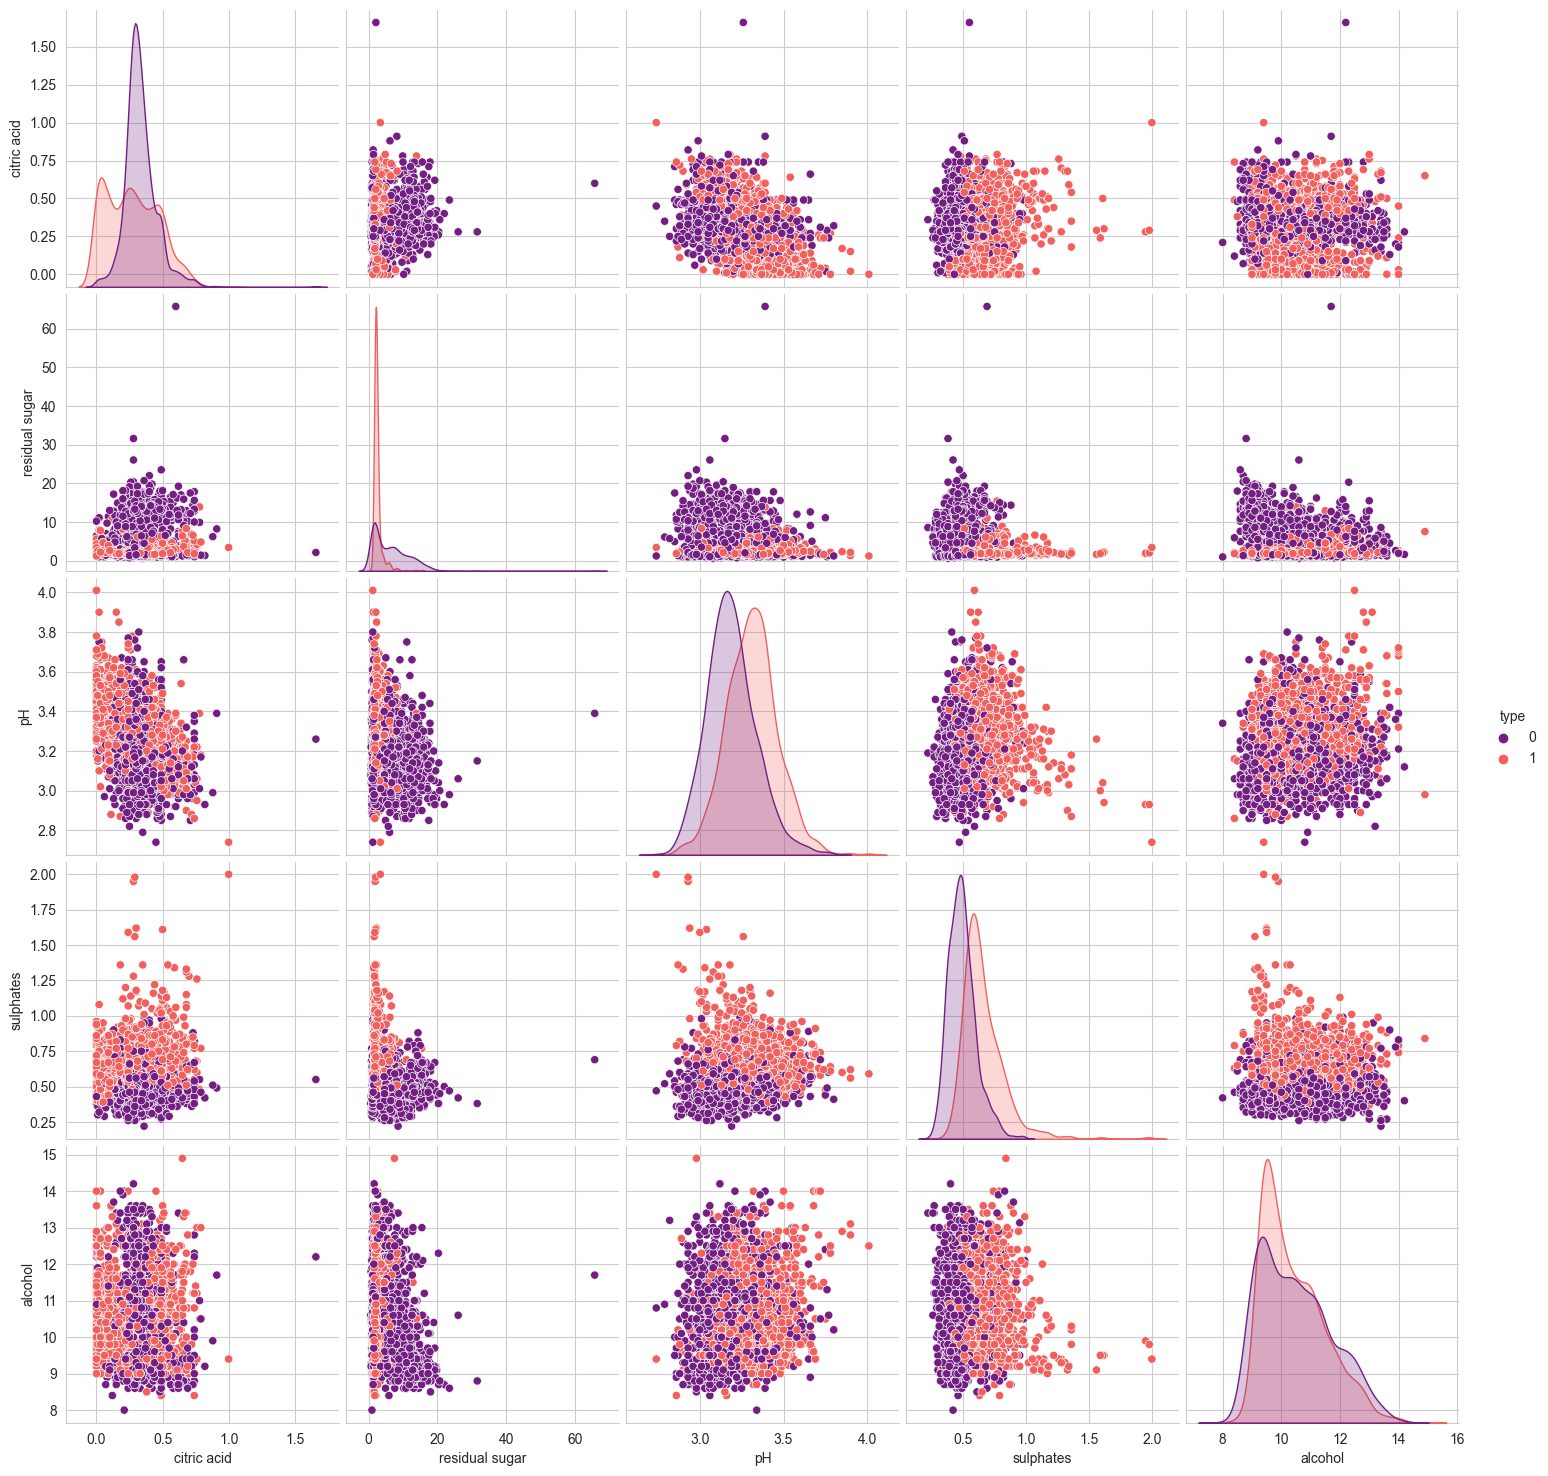

In [11]:
pp = sns.pairplot(df, hue="type", palette="magma", height=3)
plt.show()

### Correlation Heatmap

                citric acid  residual sugar        pH  sulphates   alcohol  \
citric acid        1.000000        0.155350 -0.426032   0.110082  0.042860   
residual sugar     0.155350        1.000000 -0.299052  -0.236913 -0.244032   
pH                -0.426032       -0.299052  1.000000   0.139134  0.135143   
sulphates          0.110082       -0.236913  0.139134   1.000000  0.022580   
alcohol            0.042860       -0.244032  0.135143   0.022580  1.000000   
type              -0.186378       -0.453506  0.375950   0.505663 -0.032144   

                    type  
citric acid    -0.186378  
residual sugar -0.453506  
pH              0.375950  
sulphates       0.505663  
alcohol        -0.032144  
type            1.000000  


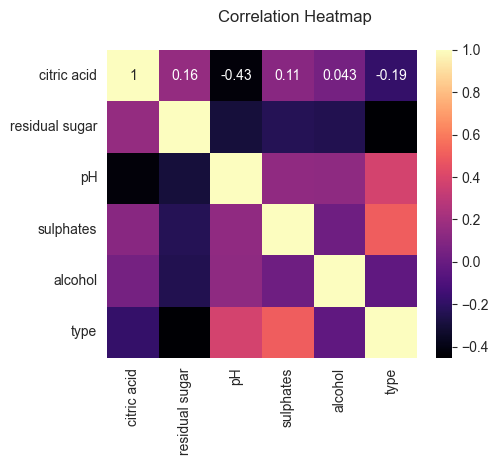

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))
corr_hm = df.corr()
print(corr_hm)
sns.heatmap(corr_hm, annot=True, cmap="magma", ax=ax)
plt.suptitle("Correlation Heatmap")
plt.show()

## Data Splitting and Cross-Validation Setup

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# using StratifiedKFold to ensure that each fold of dataset has the same proportion of observations with a given label
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Hyperparameter Tuning

In [14]:
param = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None] + list(range(1, 16)),
    "pruning": [False, True],
    "pruning_ratio": [0.1, 0.2, 0.3, 0.4, 0.5]
}

## Hyperparameter Evaluation

In [15]:
def evaluate_hyperparameters(param, use_sklearn=False):
    """
    Evaluate different hyperparameter settings for a decision tree model.

    Parameters:
    param (dict): Dictionary containing hyperparameters.
    use_sklearn (bool): Whether to use sklearn's DecisionTreeClassifier or a custom model.

    Returns:
    dict: A dictionary containing averaged training and validation results for each hyperparameter setting.
    """
    avg_results = {}

    def find_best_ccp_alpha(X, y, criterion, depth):
        """
        Find the best ccp_alpha value using cross-validation.

        Parameters:
        X (np.array): Feature matrix.
        y (np.array): Target vector.
        criterion (str): Criteria for split quality ("gini" or "entropy").
        depth (int): Maximum depth of the tree.

        Returns:
        float: Best ccp_alpha value.
        """
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=seed)
        path = clf.cost_complexity_pruning_path(X, y)
        ccp_alphas = path.ccp_alphas[1:-1]  # exclude the first (no pruning) and the last (maximum pruning)

        # the tree is either too simple or the data doesn't have enough variability to produce intermediate pruning values
        if len(ccp_alphas) == 0:
            return 0

        scores = []
        for alpha in ccp_alphas:
            clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth, ccp_alpha=alpha, random_state=seed)
            score = np.mean(cross_val_score(clf, X, y, cv=5))
            scores.append(score)

        best_index = np.argmax(scores)
        return ccp_alphas[best_index]

    def train_and_evaluate(criterion, depth, prune, ratio=None):
        """
        Train and evaluate a decision tree model based on given hyperparameters.

        Parameters:
        criterion (str): Criteria for split quality ("gini" or "entropy").
        depth (int): Maximum depth of the tree.
        prune (bool): Whether to prune the tree or not.
        ratio (float, optional): Ratio of data to use for pruning. Only used if "prune" is True.

        Returns:
        tuple: If using sklearn, returns (best ccp_alpha, list of training accuracies, list of validation accuracies). Otherwise, returns (list of training accuracies, list of validation accuracies).
        """
        train_accuracies = []
        val_accuracies = []
        best_alpha = 0

        for train_index, val_index in skf.split(X_train_val, y_train_val):
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            y_train, y_val = y_train_val[train_index], y_train_val[val_index]

            if use_sklearn:
                if prune:
                    best_alpha = find_best_ccp_alpha(X_train, y_train, criterion, depth)
                    tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth, ccp_alpha=best_alpha)
                else:
                    tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
                tree.fit(X_train, y_train)
                y_train_pred = tree.predict(X_train)
                y_val_pred = tree.predict(X_val)
            else:
                tree = DecisionTree(criterion=criterion, max_depth=depth)
                tree.learn(X_train, y_train, prune=prune, pruning_ratio=ratio)
                y_train_pred = [tree.predict(x) for x in X_train]
                y_val_pred = [tree.predict(x) for x in X_val]

            train_accuracy = accuracy_score(y_train_pred, y_train)
            val_accuracy = accuracy_score(y_val_pred, y_val)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        if use_sklearn:
            return best_alpha, train_accuracies, val_accuracies
        else:
            return train_accuracies, val_accuracies

    for criterion in param["criterion"]:
        for depth in param["max_depth"]:
            for prune in param["pruning"]:
                if use_sklearn:
                    ccp_alpha, train_accuracies, val_accuracies = train_and_evaluate(criterion, depth, prune)
                    key = (criterion, depth, prune, ccp_alpha)
                    avg_results[key] = (np.mean(train_accuracies), np.mean(val_accuracies))
                else:
                    if prune:
                        for ratio in param["pruning_ratio"]:
                            train_accuracies, val_accuracies = train_and_evaluate(criterion, depth, prune, ratio)
                            key = (criterion, depth, prune, ratio)
                            avg_results[key] = (np.mean(train_accuracies), np.mean(val_accuracies))
                    else:
                        train_accuracies, val_accuracies = train_and_evaluate(criterion, depth, prune)
                        key = (criterion, depth, prune, None)
                        avg_results[key] = (np.mean(train_accuracies), np.mean(val_accuracies))

    return avg_results

In [16]:
hyperparameters_acc = evaluate_hyperparameters(param)

In [17]:
skl_hyperparameters_acc = evaluate_hyperparameters(param, use_sklearn=True)

In [18]:
hyperparameters_acc

{('entropy', None, False, None): (1.0, 0.8897604268590997),
 ('entropy', None, True, 0.1): (0.8637792902948837, 0.8076015166340508),
 ('entropy', None, True, 0.2): (0.9137014279772367, 0.8643514554794521),
 ('entropy', None, True, 0.3): (0.8310093067078113, 0.7951856042074363),
 ('entropy', None, True, 0.4): (0.822119535968284, 0.7865750366927593),
 ('entropy', None, True, 0.5): (0.876857437701789, 0.8350240031800391),
 ('entropy', 1, False, None): (0.7452119091859388, 0.7423831947162427),
 ('entropy', 1, True, 0.1): (0.7451138709534157, 0.7439510457436399),
 ('entropy', 1, True, 0.2): (0.7436475475399471, 0.7435611851761252),
 ('entropy', 1, True, 0.3): (0.7461879459295032, 0.7451267429060665),
 ('entropy', 1, True, 0.4): (0.7432553946098551, 0.7384861179060664),
 ('entropy', 1, True, 0.5): (0.7492182489598063, 0.7462986179060664),
 ('entropy', 2, False, None): (0.8222246894938638, 0.819003027152642),
 ('entropy', 2, True, 0.1): (0.726866104988298, 0.7172433035714286),
 ('entropy', 2,

In [19]:
skl_hyperparameters_acc

{('entropy', None, False, 0): (1.0, 0.8870207008317026),
 ('entropy', None, True, 0.0006729085251986977): (0.9403796701273732,
  0.8897573691291585),
 ('entropy', 1, False, 0): (0.7452119091859388, 0.7423831947162427),
 ('entropy', 1, True, 0): (0.7452119091859388, 0.7423831947162427),
 ('entropy', 2, False, 0): (0.8222246894938638, 0.819003027152642),
 ('entropy', 2, True, 0.026672639338283538): (0.8214429623304925,
  0.8182225415851272),
 ('entropy', 3, False, 0): (0.8601444738766075, 0.8526204745596869),
 ('entropy', 3, True, 0.026672639338283538): (0.8552579389240436,
  0.8475347052348337),
 ('entropy', 4, False, 0): (0.88242785259978, 0.8666967343444227),
 ('entropy', 4, True, 0.002594719392691739): (0.88242785259978,
  0.8666967343444227),
 ('entropy', 5, False, 0): (0.8971849226462586, 0.8698209699119375),
 ('entropy', 5, True, 0.003269969207258234): (0.895230174955028,
  0.8670873593444227),
 ('entropy', 6, False, 0): (0.9131150609742411, 0.8811597969667317),
 ('entropy', 6, Tr

## Model Accuracies Across Hyperparameters

In [20]:
cmap = plt.cm.magma(np.linspace(0, 1, 15))

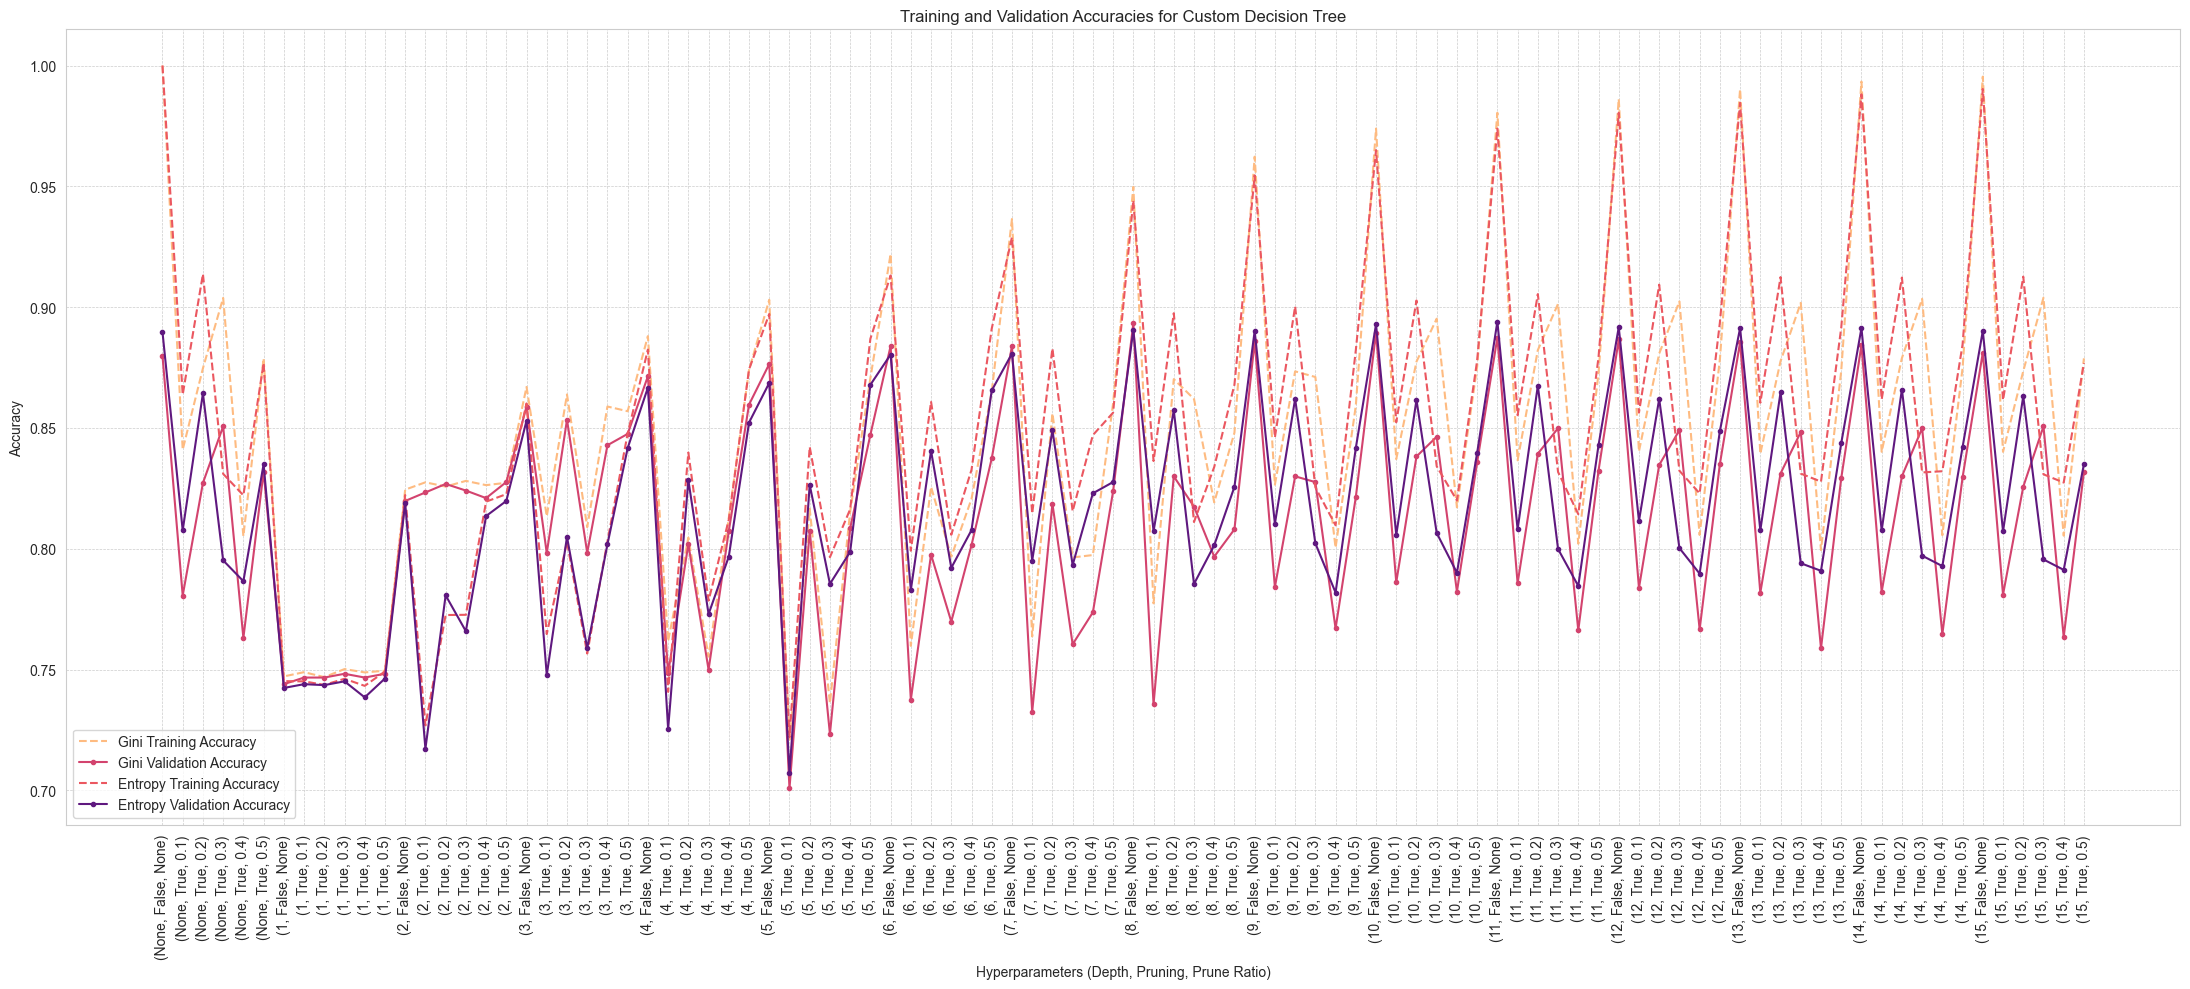

In [21]:
gini_train_accuracies = [value[0] for key, value in hyperparameters_acc.items() if key[0] == "gini"]
gini_val_accuracies = [value[1] for key, value in hyperparameters_acc.items() if key[0] == "gini"]
entropy_train_accuracies = [value[0] for key, value in hyperparameters_acc.items() if key[0] == "entropy"]
entropy_val_accuracies = [value[1] for key, value in hyperparameters_acc.items() if key[0] == "entropy"]

labels = [str(key[1:]) for key in hyperparameters_acc.keys() if key[0] == "gini"]

plt.figure(figsize=(22, 10))
plt.plot(labels, gini_train_accuracies, linestyle="--", label="Gini Training Accuracy", color=cmap[12])
plt.plot(labels, gini_val_accuracies, marker=".", label="Gini Validation Accuracy", color=cmap[8])
plt.plot(labels, entropy_train_accuracies, linestyle="--", label="Entropy Training Accuracy", color=cmap[9])
plt.plot(labels, entropy_val_accuracies, marker=".", label="Entropy Validation Accuracy", color=cmap[4])
plt.xlabel("Hyperparameters (Depth, Pruning, Prune Ratio)")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies for Custom Decision Tree")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

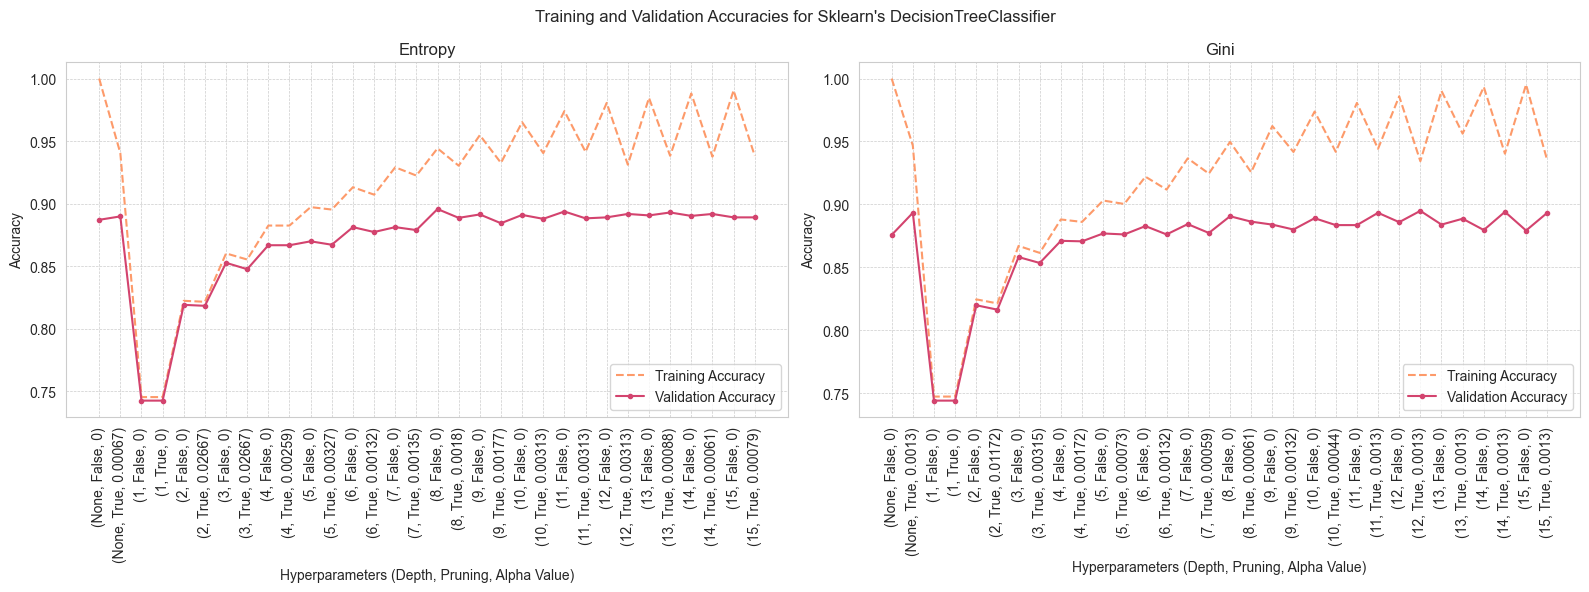

In [22]:
skl_rounded_results = {(k[0], k[1], k[2], round(k[3], 5)): v for k, v in skl_hyperparameters_acc.items()}

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for idx, impurity in enumerate(["entropy", "gini"]):
    impurity_results = {k: v for k, v in skl_rounded_results.items() if k[0] == impurity}

    labels = [str(key[1:]) for key in impurity_results]
    train_accuracies = [value[0] for value in impurity_results.values()]
    val_accuracies = [value[1] for value in impurity_results.values()]

    axs[idx].plot(labels, train_accuracies, linestyle="--", label="Training Accuracy", color=cmap[11])
    axs[idx].plot(labels, val_accuracies, marker=".", label="Validation Accuracy", color=cmap[8])
    axs[idx].set_title(f"{impurity.capitalize()}")
    axs[idx].set_xlabel("Hyperparameters (Depth, Pruning, Alpha Value)")
    axs[idx].set_ylabel("Accuracy")
    axs[idx].tick_params(axis="x", rotation=90)
    axs[idx].legend()
    axs[idx].grid(True, which="both", linestyle="--", linewidth=0.5)

fig.suptitle("Training and Validation Accuracies for Sklearn's DecisionTreeClassifier")
plt.tight_layout()
plt.show()

In [32]:
def evaluate_model(hyperparam_acc):
    """
    Evaluate the model based on hyperparameter settings and accuracies.
    
    Parameters:
    hyperparameters_acc (dict): Dictionary with hyperparameters as keys and their corresponding accuracies as values.
    
    Returns:
    tuple: Best hyperparameter setting.
    """
    best_setting = max(hyperparam_acc, key=lambda k: hyperparam_acc[k][1])
    print(f"Best Setting:", best_setting)
    print(f"Training Accuracy for Best Setting: {hyperparam_acc[best_setting][0] * 100:.2f}%")
    print(f"Validation Accuracy for Best Setting: {hyperparam_acc[best_setting][1] * 100:.2f}%")
    return best_setting


def test_model(tree, X_train, y_train, X_test, y_test, prune=None, ratio=None, use_sklearn=False):
    """
    Test the model's performance on the test dataset.
    
    Parameters:
    tree (object): The decision tree model to be tested.
    X_train (np.array): Training features.
    y_train (list): Training labels.
    X_test (np.array): Test features.
    y_test (list): Test labels.
    prune (str, optional): Pruning method. Defaults to None.
    ratio (float, optional): Pruning ratio. Defaults to None.
    use_sklearn (bool, optional): Whether to use scikit-learn's decision tree. Defaults to False.
    
    Returns:
    list: Predicted labels for the test dataset.
    """
    start_time = time.time()
    if use_sklearn:
        tree.fit(X_train, y_train)
    else:
        tree.learn(X_train, y_train, prune=prune, pruning_ratio=ratio)
    train_time = time.time() - start_time

    y_test_pred = tree.predict(X_test) if use_sklearn else [tree.predict(x) for x in X_test]

    test_accuracy = accuracy_score(y_test_pred, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Training Time: {train_time:.5f}s")

    return y_test_pred


def plot_feature_importance(tree, features, model_name, X_train=None, y_train=None, use_sklearn=False):
    """
    Plot the feature importance for the decision tree model.

    Parameters:
    tree (object): The decision tree model.
    features (list): List of feature names.
    model_name (str): Name of the model.
    X_train (np.array, optional): Training features. Defaults to None.
    y_train (list, optional): Training labels. Defaults to None.
    use_sklearn (bool, optional): Whether to use scikit-learn's decision tree. Defaults to False.
    """
    if not use_sklearn:
        tree.compute_feature_importance(X_train, y_train)
    importances = tree.feature_importances_

    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = np.array(importances)[sorted_indices]
    sorted_features = np.array(features)[sorted_indices]

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=sorted_importances, y=sorted_features, palette="magma")

    for index, value in enumerate(sorted_importances):
        ax.text(value + 0.01, index, "{:.3f}".format(value), color="black", ha="left", va="center")

    ax.set_xlim(0, 1)
    plt.title(f"{model_name} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()


def plot_confusion_matrix(y_test, y_test_pred, model_name):
    """
    Plot the confusion matrix for the model's predictions.

    Parameters:
    y_test (list): True test labels.
    y_test_pred (list): Predicted test labels.
    model_name (str): Name of the model.
    """
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="g", cmap="flare")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

## Custom DecisionTree Evaluation, Testing, and Plotting

In [24]:
custom_model_name = "Custom DecisionTree"
best_setting = evaluate_model(hyperparameters_acc)
criterion, depth, prune, ratio = best_setting

Best Setting: ('entropy', 11, False, None)
Training Accuracy for Best Setting: 97.39%
Validation Accuracy for Best Setting: 89.41%


In [25]:
tree = DecisionTree(criterion=criterion, max_depth=depth)
y_test_pred = test_model(tree, X_train_val, y_train_val, X_test, y_test, prune, ratio)

Test Accuracy: 91.88%
Training Time: 0.55065s


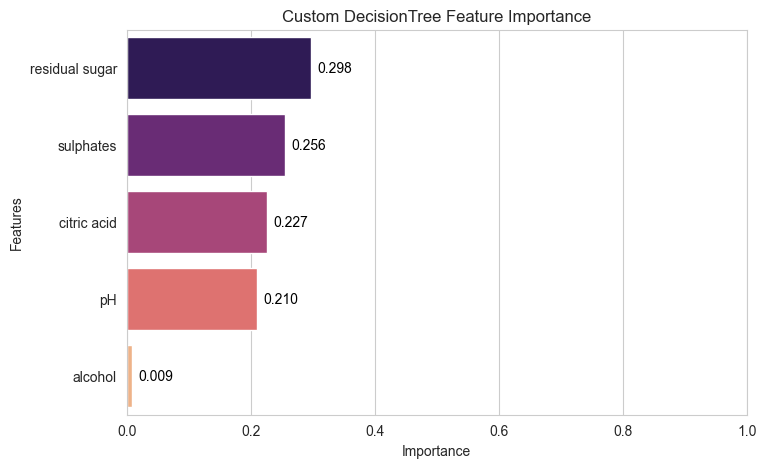

In [26]:
plot_feature_importance(tree, features, custom_model_name, X_train_val, y_train_val)

[[299  31]
 [ 21 289]]


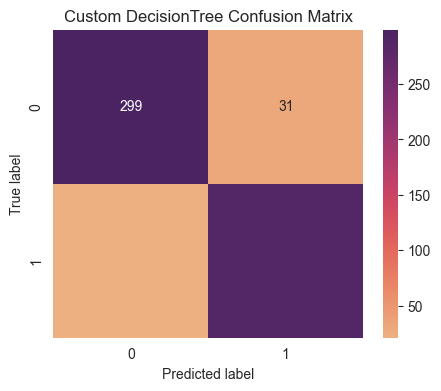

In [33]:
plot_confusion_matrix(y_test, y_test_pred, custom_model_name)

## Scikit-learn's DecisionTreeClassifier Evaluation, Testing, and Plotting

In [28]:
skl_model_name = "DecisionTreeClassifier"
skl_best_setting = evaluate_model(skl_hyperparameters_acc)
skl_criterion, skl_depth, skl_prune, skl_ccp_alpha = skl_best_setting

Best Setting: ('entropy', 8, False, 0)
Training Accuracy for Best Setting: 94.42%
Validation Accuracy for Best Setting: 89.56%


In [29]:
skl_tree = DecisionTreeClassifier(criterion=skl_criterion, max_depth=skl_depth, ccp_alpha=skl_ccp_alpha,
                                  random_state=seed)
skl_y_test_pred = test_model(skl_tree, X_train_val, y_train_val, X_test, y_test, use_sklearn=True)

Test Accuracy: 90.16%
Training Time: 0.00453s


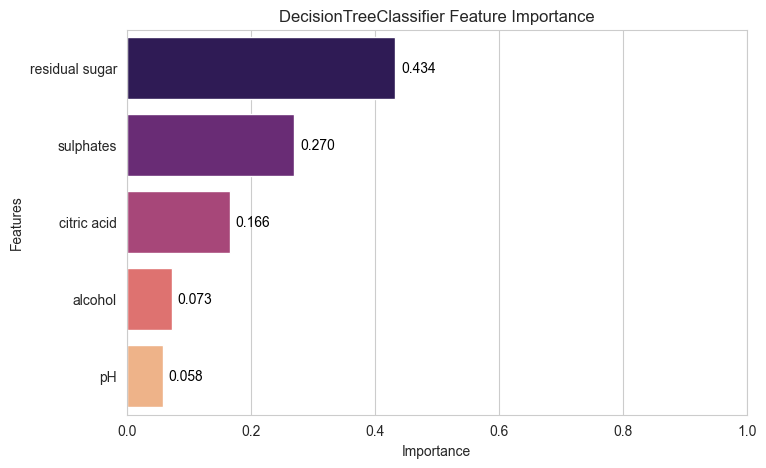

In [30]:
plot_feature_importance(skl_tree, features, skl_model_name, use_sklearn=True)

[[285  45]
 [ 18 292]]


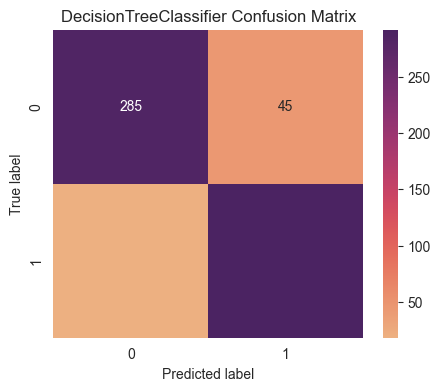

In [34]:
plot_confusion_matrix(y_test, skl_y_test_pred, skl_model_name)